# Problem Set 2

In this exercise, you will use 311 Dataset to determine whether to focus on any particular borough, ZIP code, or street (where the complaints are severe) for the specific Complaint Type you decided to focus at the end of the last exercise.

In [1]:
## Import important packages and set up notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.style.use('ggplot')
import matplotlib.cm as cm
import seaborn as sns

import pandas as pd
import pandas_profiling
import numpy as np
from numpy import percentile
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p

import os, sys
import calendar
import matplotlib.pyplot as plt


## Some default plot settings
plt.rc('font', size=18)        
plt.rc('axes', titlesize=22)      
plt.rc('axes', labelsize=18)      
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)     
plt.rc('legend', fontsize=12)   

local = True
if (local):
    BASE_PATH = "../"

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_311 = pd.read_csv(f"{BASE_PATH}nyc311.csv",index_col='unique_key')

In [17]:
print(df_311.shape)


#df_311[df_311['borough']=='Unspecified'].head(20)

(5895877, 14)


### In the last exercise we found that HEAT/HOT Water and Heating were the top complaints. They are kind of degenerate so we should take them both.

In [4]:
df = df_311[((df_311['complaint_type'] == 'HEAT/HOT WATER') | (df_311['complaint_type'] == 'HEATING'))]
df['complaint_type'].value_counts()
## check that the df_311 dataframe was correctly spliced
print(df_311['complaint_type'].value_counts()['HEAT/HOT WATER'] == df['complaint_type'].value_counts()['HEAT/HOT WATER'])
print(df_311['complaint_type'].value_counts()['HEATING'] == df['complaint_type'].value_counts()['HEATING'])

True
True


### We should check which columns have NaN

In [5]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percentage"])
missing = missing[missing.percentage > 0]
display(missing.sort_values("percentage", ascending=False))

,column_name,percentage
2,incident_zip,0.921536
9,latitude,0.921342
10,longitude,0.921342
6,city,0.914933
11,closed_date,0.875653
5,address_type,0.873760
7,resolution_description,0.010973
3,incident_address,0.000049
4,street_name,0.000049


### We will drop columns with NaNs in Lat , Long, and Zip since we are using these for our analysis. If they are muturally exclusive it will total at most 3% of the data. Which is acceptable loss

In [6]:
#print(df.shape[0])
df_new = df.dropna(subset=['longitude', 'latitude','incident_zip'])
print("We have dropped %.2f percent of the data" %((1-df_new.shape[0]/df.shape[0])*100))
df = df_new

We have dropped 0.92 percent of the data


In [7]:
df['incident_zip'] = df['incident_zip'].astype(int)

## We should fix the Boroughless entries if we can.

In [8]:
## Need to correct some of the 'Unspecified'
def borough_fix(city,zip_code):
    ### 1rst check if the borough is listed as the city
    bor_list = ['BRONX','BROOKLYN','MANHATTEN','QUEENS','STATEN ISLAND']
    brooklyn_zip = [11212, 11213, 11216, 11233, 11238,11209, 11214, 11228,
                  11204, 11218, 11219, 11230,
                  11234, 11236, 11239,
                  11223, 11224, 11229, 11235,
                  11201, 11205, 11215, 11217, 11231,
                  11203, 11210, 11225, 11226,
                  11207, 11208, 11211, 11222,
                  11220, 11232, 11206, 11221, 11237]
    queens_zip = [
        11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358, 11359, 11360,
        11365, 11366, 11367, 11412, 11423, 11432, 11433, 11434, 11435, 11436,
        11101, 11102, 11103, 11104, 11105, 11106, 11374, 11375, 11379, 11385,
        11691, 11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411, 11413, 
        11422, 11426, 11427, 11428, 11429, 11414, 11415, 11416, 11417, 11418, 
        11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377, 11378
    ]
    
    if city in bor_list:
        return city
    
    ### If not check the zipcode and match with borough
    # zipcodes from https://www.quora.com/What-is-the-ZIP-code-numbering-plan-for-New-York-City
    # https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
    if zip_code in range(10000,10199):
        return 'MANHATTEN'
    if zip_code in range(10300,10400):
        return 'STATEN ISLAND'
    if zip_code in range(10400,10500):
        return 'BRONX'
    if zip_code in brooklyn_zip:
        return 'BROOKLYN'
    if zip_code in queens_zip:
        return 'QUEENS'
    else:
        return 'Unspecified'

df['borough'] = df.apply(lambda x: borough_fix(x['city'],x['incident_zip']) if (x['borough'] == 'Unspecified') 
                         else x['borough'] ,axis=1)

### Since we have the Latitude and Longitude of the complaints we can map the complaints 
### <span style="color:red">Not all data is displayed </span>

In [9]:
import folium
from folium import plugins

#Set up a map of NYC
nyc = [40.7128,-74.0060]
nyc_map = world_map = folium.Map(location=nyc, zoom_start=10) 

number = 2000

## Add marker clusters to the NYC map
complaints = plugins.MarkerCluster().add_to(nyc_map)

for lat, lng, label, in zip(df['latitude'].head(number), df['longitude'].head(number),df['incident_zip'].astype(int).astype(str).head(number)):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(complaints)


### Show the map

In [10]:
nyc_map

### We could also look at the data by borough

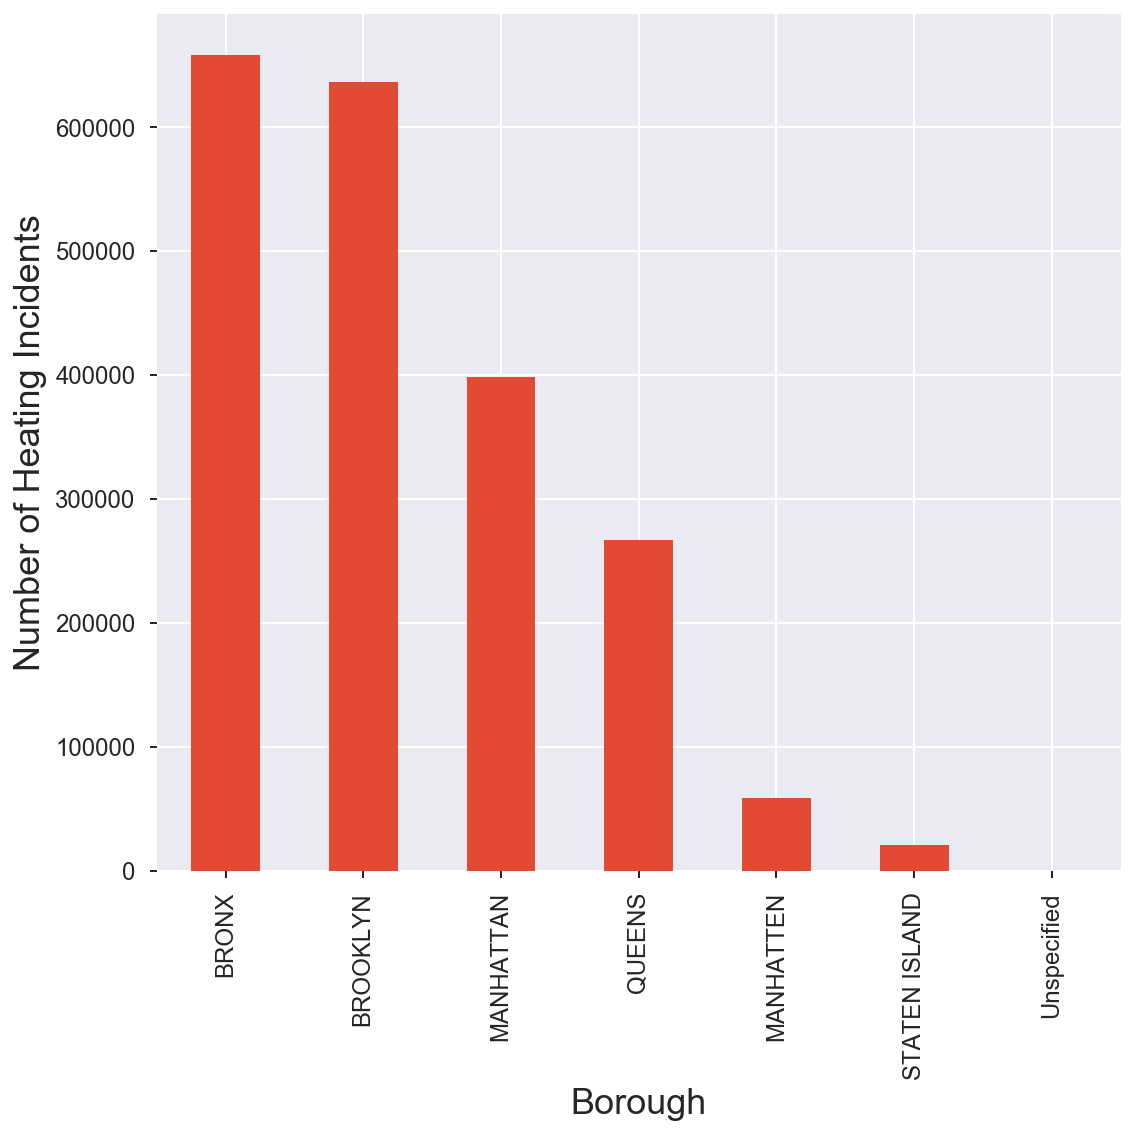

In [16]:
plt.figure(figsize=(8,8))
df['borough'].value_counts().plot(kind='bar')
plt.ylabel('Number of Heating Incidents')
plt.xlabel('Borough')
plt.tight_layout()
#df[df['borough']=='Unspecified'].head(40)

### We can clearly see that the BRONX has the highest number of complaints followed by Brooklyn. Therefore we should focus on the Bronx

### A similar approach can be taken to look at incidents by street. 

In [12]:
df_street = df.dropna(subset=['street_name'])
df_street['incident_zip'] = df_street['incident_zip'].astype(int).astype(str)
df_street['street_name'] = df_street['street_name'].str.strip()
df_street['street_name'] = (df_street['street_name'].str.split()).str.join(' ')

In [13]:
df_street_group = df_street.groupby(['street_name'],as_index=False).count()
df_street_group['Percent'] = df_street_group['city']/df_street_group['city'].sum()*100
df_street_group = df_street_group[['street_name','Percent']] 
df_street_group = df_street_group[df_street_group['Percent']>.5].sort_values(by='Percent',ascending=False)

<Figure size 576x576 with 0 Axes>

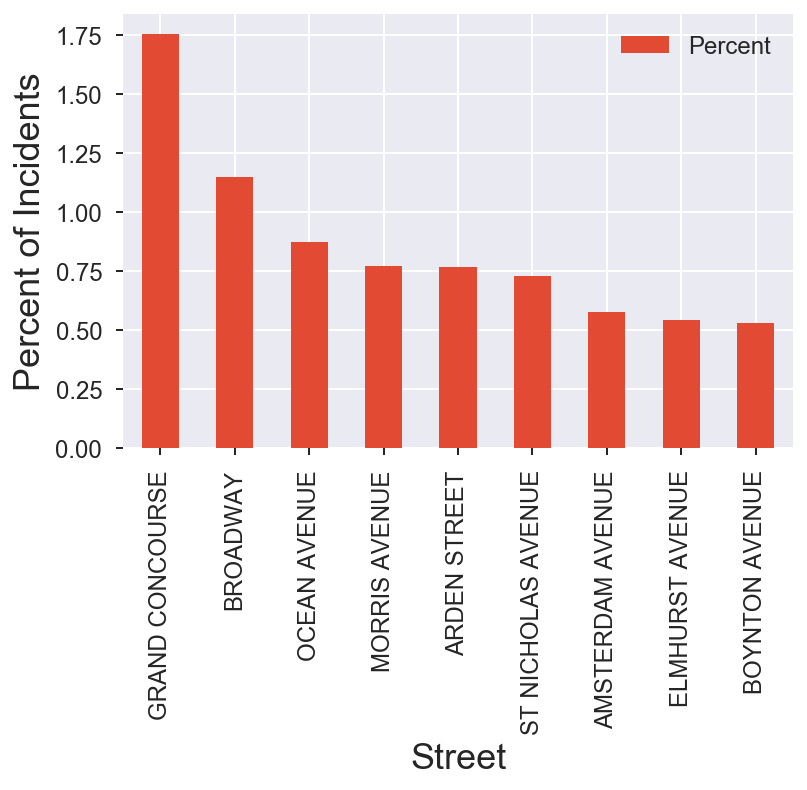

In [14]:
plt.figure(figsize=(8,8))
df_street_group.plot(kind='bar', y = 'Percent',x = 'street_name')
plt.ylabel('Percent of Incidents')
plt.xlabel('Street')
#plt.tight_layout()
plt.show()

#### The issue with using this analysis is that it the leading 9 streets only make up less than 10% of the total incidents. Plus it does not give geological location on the incidents. It could be more useful to see the geological locations so that energy can be put into eliminating custers.

### Finally we can repeat the procedure for zip codes to visualize the distribution

,NumberComplaints,Percent
11226,66126,3.240478
10467,63329,3.103412
10458,62693,3.072245
10468,55471,2.718334
10453,55287,2.709317
10452,47865,2.345605
10457,43720,2.142481
10040,43522,2.132778
10031,43096,2.111902
10456,42351,2.075394


The sum of the top 5 zipcodes is: 14.84 percent


<Figure size 576x576 with 0 Axes>

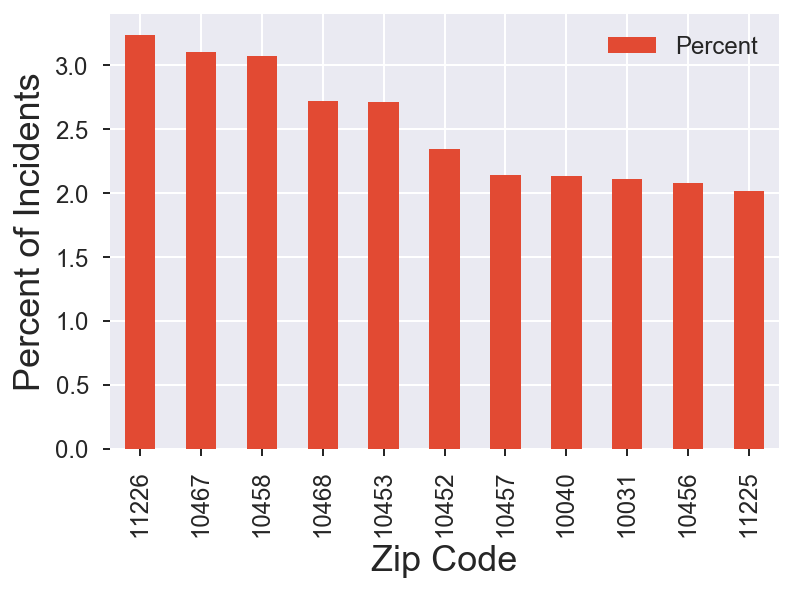

In [15]:
df_zip= df['incident_zip'].astype(int).astype(str).value_counts().to_frame()
df_zip.rename(columns={'incident_zip':'NumberComplaints'},inplace=True)
df_zip['Percent'] = df_zip['NumberComplaints']/df_zip['NumberComplaints'].sum()*100
df_zip = df_zip[df_zip['Percent']>2]
display(df_zip.head(20))
zip_num = 5
print("The sum of the top %.i zipcodes is: %.2f percent" %(zip_num, df_zip['Percent'].head(zip_num).sum() ))
plt.figure(figsize=(8,8))
df_zip.plot(kind='bar', y = 'Percent')
plt.ylabel('Percent of Incidents')
plt.xlabel('Zip Code')
#plt.tight_layout()
plt.show()

### A similar issues exists here. There is not a clear target to maximize efforts. The top zip codes only cover a couple percent. However, in this case it is clear that focusing on the top 3 zipcodes would eliminate ~10% of the complaints

## Question: Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

### Answer: Yes, the Department of Housing Preservation and Development of NYC should focus first on the Bronx and then Brooklyn. We can see from our histogram that those two boroughs have the most complains.